#Assignment 2


Submissions: Yuval Rubinstein, Yael Herman, Or Somech and Adi Finkelstein

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sklearn
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import re

Loading the data

In [ ]:
train_df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/test.csv')

##Data exploration

In [ ]:
train_df

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70405 entries, 0 to 70404
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Dialogue         70405 non-null  object
 1   Character        70405 non-null  object
 2   Episode          70405 non-null  object
 3   Show             70405 non-null  object
 4   Dialogue_length  70405 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


We can see that there are no NULL values in the data. Also, there are 70405 rows and 5 columns.

In [ ]:
train_df.nunique()

Dialogue           62770
Character             10
Episode              398
Show                   2
Dialogue_length      163
dtype: int64

We can see that some dialogues repeart themselves - since the number of unique dialogues is smaller than the total number of samples. Also, we see that we have 2 show type, which means that each show name is always written in the same way.

In [ ]:
train_df['Dialogue_length'].describe()

count    70405.000000
mean        11.002131
std         12.125423
min          1.000000
25%          4.000000
50%          8.000000
75%         14.000000
max        363.000000
Name: Dialogue_length, dtype: float64

The mean length of a line in the data is 11 words. Hoever, the longest line in the data contains 363 words, while the shortest contains 1 word. This fact might be helpfull for us to detect which charecter in which TV show say longer or shorter lines usually, if there is one.

Let's look at an example of one of the lines

In [ ]:
train_df.iloc[1, 0]

' (to Joey) Are you gonna be embarrassed going up there having nothing prepared?'

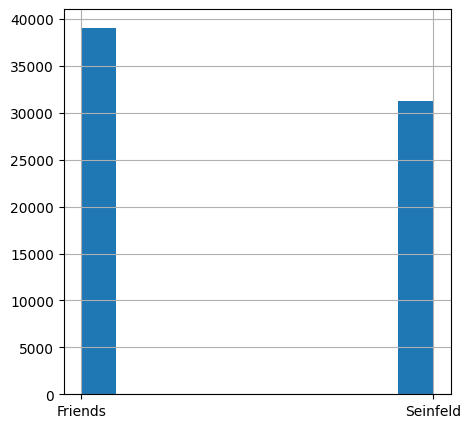

Friends     39092
Seinfeld    31313
Name: Show, dtype: int64

In [ ]:
y_train = train_df['Show']

y_train.hist(bins =10, figsize = (5,5))
plt.show()
y_train.value_counts()


We can see that Friends has more samples than Seinfeld, but the differece doesn't seem problematic for our model



In [ ]:
copy_train_df = train_df[['Show', 'Dialogue_length', "Character"]].copy()
copy_train_df['Show'] = copy_train_df['Show'].replace({'Friends': 0, 'Seinfeld': 1})

# Use factorize to map each unique character to a unique number
copy_train_df['Character'], unique_numbers = pd.factorize(copy_train_df['Character'])
string_to_number = dict(zip(copy_train_df['Character'].unique(), unique_numbers))
print(string_to_number)

copy_train_df

{0: 'joey', 1: 'phoebe', 2: 'elaine', 3: 'chandler', 4: 'kramer', 5: 'monica', 6: 'ross', 7: 'george', 8: 'rachel', 9: 'jerry'}


,Show,Dialogue_length,Character
0,0,1,0
1,0,13,1
2,1,14,2
3,0,56,3
4,1,13,4
...,...,...,...
70400,1,2,9
70401,0,22,1
70402,0,7,1
70403,1,9,9


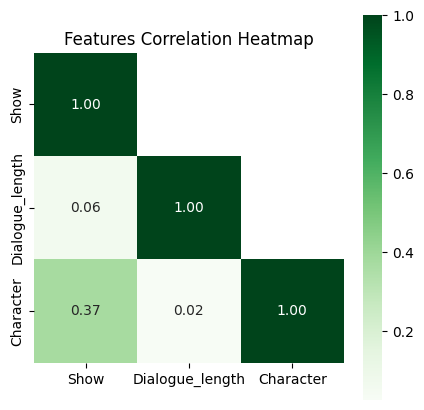

In [ ]:
corr_mat_original = copy_train_df.corr().abs()
mask = np.array(corr_mat_original)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(5, 5))
plt.title('Features Correlation Heatmap')
sns.heatmap(corr_mat_original, mask=mask, annot=True, square = True, cmap="Greens", fmt='.2f')
plt.show()

We created a copy df that converts the show/character values to unique numbers in order to check the correlation matrix between these features and the dialogue_length.
However we can see that there is no strong correlation at this point.



## Data preprocessing:

In [ ]:
# change all text to lower case:
train_df['Dialogue'] = train_df['Dialogue'].str.lower()

In [ ]:
# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

# Apply function on dialogue column
train_df['Dialogue'] = train_df['Dialogue'].apply(remove_special_characters)
test_df['Dialogue'] = test_df['Dialogue'].apply(remove_special_characters)

In [ ]:
train_df.iloc[1, 0]

' to joey are you gonna be embarrassed going up there having nothing prepared'

We can see the that "()" is now gone. The removal of special characters can be helpfull but also can be sometimes confusing, as we can see in the example above - The words "to Joey" are not really a part of the sentence.


Removing stop words - we download all English stop words that NLTK offers and look at a few of them:

In [ ]:
import nltk
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
print('Number of English stop words:', len(stopword_list))
print(stopword_list[:5])

Number of English stop words: 179
['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We want to remove those words from our text. In order to do that we need to create a ToktokTokenizer instace. Let's see what it does to our example:



In [ ]:
from nltk.tokenize.toktok import ToktokTokenizer

tokenizer = ToktokTokenizer()
tokenizer.tokenize(train_df.iloc[1, 0])

['to',
 'joey',
 'are',
 'you',
 'gonna',
 'be',
 'embarrassed',
 'going',
 'up',
 'there',
 'having',
 'nothing',
 'prepared']

Removing the stopwords:

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


train_df['Dialogue'] = train_df['Dialogue'].progress_apply(remove_stopwords)
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(remove_stopwords)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [ ]:
train_df.iloc[1, 0]

'joey gonna embarrassed going nothing prepared'

stemming

In [ ]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    stemmed_words_list = []
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

train_df['Dialogue'] = train_df['Dialogue'].progress_apply(simple_stemmer)
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(simple_stemmer)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [ ]:
train_df.iloc[1, 0]

'joey gonna embarrass go noth prepar'

### Train-Test-Valdiation split:

We also tried to shuffle the data set but it did not improve the model results so we put that line as a comment

In [ ]:
#train_df = train_df.sample(frac=1).reset_index(drop=True)
X_train = train_df['Dialogue']
Y_train = train_df['Show']

x_test = test_df['Dialogue']
y_test = test_df['Show']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=1/16, random_state=1234)

Checking labels ratio of our datasets to see if they're skewed:

In [ ]:
train_label_count = y_train.value_counts()
test_label_count = y_test.value_counts()
val_label_count = y_val.value_counts()

print('Train Friends to Seinfeld ratio:', train_label_count['Friends'] / train_label_count['Seinfeld'])
print('Validation Friends to Seinfeld ratio:', val_label_count['Friends'] / val_label_count['Seinfeld'])
print('Test Friends to Seinfeld ratio:', test_label_count['Friends'] / test_label_count['Seinfeld'])

Train Friends to Seinfeld ratio: 1.2487819835780722
Validation Friends to Seinfeld ratio: 1.2431192660550459
Test Friends to Seinfeld ratio: 1.5742874469375379


In [ ]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (66004,)
y_train shape: (66004,)
x_test shape: (4245,)
y_test shape: (4245,)
x_val shape: (4401,)
y_val shape: (4401,)


###Labeling:
In a similar way to what we did in the exploration, we need to convert the show name values to ones and zeros

In [ ]:
# example from the data
y_train[:5]

56129    Seinfeld
40114     Friends
61139     Friends
35338    Seinfeld
6495     Seinfeld
Name: Show, dtype: object

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

In [ ]:
# example of the data after the formatting
y_train[:5]

array([[1],
       [0],
       [0],
       [1],
       [1]])

"Seinfeld" got the value of 1 and "Friends" got the value 0.

# Building a DL model of the problem


In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

Using Keras' tokenizer to convert to sequences

In [ ]:
token = Tokenizer(lower=False)
token.fit_on_texts(x_train)

In [ ]:
x_train_dl = token.texts_to_sequences(x_train)
x_val_dl = token.texts_to_sequences(x_val)
x_test_dl = token.texts_to_sequences(x_test)

Let's see our example line after the conversion to sequence:

In [ ]:
x_train_dl[0]

[102, 315, 2163, 618, 500, 8821]

Calculate dialogue lengths:

In [ ]:
doc_len_list = [len(doc) for doc in x_train_dl]

print("Max length:", max(doc_len_list), "\nMin length:", min(doc_len_list), "\nMean length:", np.mean(doc_len_list))

Max length: 185 
Min length: 0 
Mean length: 5.818965517241379


Let's examine the distribution of the lengths

<Axes: ylabel='Count'>

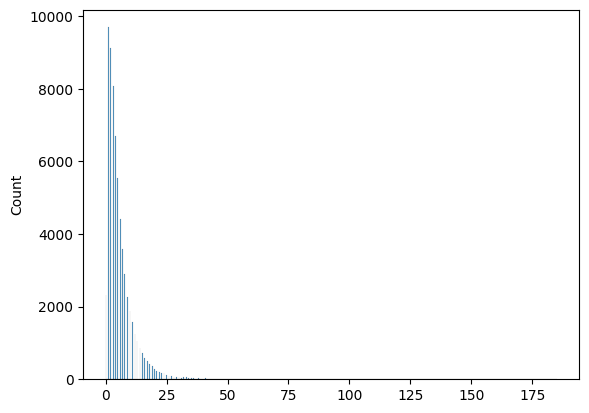

In [ ]:
sns.histplot(doc_len_list)

We want to make sure that all sequences have the same length. Because the longest doc isn't that long (185 words), it seems like a reasonable shared value:


In [ ]:
from keras.utils import pad_sequences

max_words = 185

x_train_dl = pad_sequences(x_train_dl, maxlen=max_words)
x_val_dl = pad_sequences(x_val_dl, maxlen=max_words)
x_test_dl = pad_sequences(x_test_dl, maxlen=max_words)

x_train_dl.shape

(66004, 185)

Let's see what a sample look like:


In [ ]:
x_train_dl[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

Let's see how many unique words we have:

In [ ]:
total_words = len(token.word_index) + 1
total_words

17055

## Embeddings:
Let's build the architecture:

In [ ]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=64, input_length=max_words))
model.add(Conv1D(8, 3, padding='same', activation='relu'))
model.add(GRU(4, return_sequences=True))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 185, 64)           1091520   
                                                                 
 conv1d (Conv1D)             (None, 185, 8)            1544      
                                                                 
 gru (GRU)                   (None, 185, 4)            168       
                                                                 
 flatten (Flatten)           (None, 740)               0         
                                                                 
 dense (Dense)               (None, 64)                47424     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
model.fit(x_train_dl, y_train, validation_data=(x_val_dl, y_val), epochs=5, batch_size=64)

Epoch 1/5
1032/1032 [==============================] - 117s 111ms/step - loss: 0.5326 - accuracy: 0.6972 - val_loss: 0.4932 - val_accuracy: 0.7262
Epoch 2/5
1032/1032 [==============================] - 96s 93ms/step - loss: 0.4340 - accuracy: 0.7724 - val_loss: 0.4923 - val_accuracy: 0.7335
Epoch 3/5
1032/1032 [==============================] - 94s 91ms/step - loss: 0.3854 - accuracy: 0.7993 - val_loss: 0.5251 - val_accuracy: 0.7373
Epoch 4/5
1032/1032 [==============================] - 91s 88ms/step - loss: 0.3464 - accuracy: 0.8199 - val_loss: 0.5537 - val_accuracy: 0.7294
Epoch 5/5
1032/1032 [==============================] - 92s 89ms/step - loss: 0.3140 - accuracy: 0.8367 - val_loss: 0.6039 - val_accuracy: 0.7253


## Model Evaluation




In [ ]:
# evaluating model on train data
acc_train = model.evaluate(x_train_dl, y_train)
acc_train

2063/2063 [==============================] - 28s 14ms/step - loss: 0.2692 - accuracy: 0.8638


[0.26924723386764526, 0.8637658357620239]

In [ ]:
# evaluating model on validation data
acc_val = model.evaluate(x_val_dl, y_val)
acc_val

138/138 [==============================] - 2s 13ms/step - loss: 0.6039 - accuracy: 0.7253


[0.603949785232544, 0.7252897024154663]

In [ ]:
# evaluating model on test data
acc_test = model.evaluate(x_test_dl, y_test)
acc_test

133/133 [==============================] - 2s 13ms/step - loss: 0.5345 - accuracy: 0.8386


[0.5345377326011658, 0.8386337161064148]

Let's make sure that we have the same 10 unique characters in the test set:



In [ ]:
characters = test_df['Character'].unique()
characters

array(['joey', 'monica', 'george', 'kramer', 'rachel', 'ross', 'phoebe',
       'jerry', 'chandler', 'elaine'], dtype=object)

For each character separately - preproccessing the data and running the model:

In [ ]:
accuracies = {}

def prepare_and_evaluate_test_data(test_df, character):
  x_test_char = test_df['Dialogue']
  y_test_char = test_df['Show']
  x_test_char_dl = token.texts_to_sequences(x_test_char)
  x_test_char_dl = pad_sequences(x_test_char_dl, maxlen=max_words)
  y_test_char = lb.transform(y_test_char)
  accuracies[character] = model.evaluate(x_test_char_dl, y_test_char)


In [ ]:
for character in characters :
    test_data = test_df[test_df['Character'] == character]
    print(character, test_data.shape)
    prepare_and_evaluate_test_data(test_data, character)

joey (472, 5)
15/15 [==============================] - 0s 13ms/step - loss: 0.4379 - accuracy: 0.8644
monica (382, 5)
12/12 [==============================] - 0s 23ms/step - loss: 0.3817 - accuracy: 0.8901
george (474, 5)
15/15 [==============================] - 0s 24ms/step - loss: 0.7223 - accuracy: 0.7869
kramer (296, 5)
10/10 [==============================] - 0s 22ms/step - loss: 0.6652 - accuracy: 0.7770
rachel (462, 5)
15/15 [==============================] - 0s 23ms/step - loss: 0.3438 - accuracy: 0.8831
ross (475, 5)
15/15 [==============================] - 0s 17ms/step - loss: 0.4194 - accuracy: 0.8821
phoebe (394, 5)
13/13 [==============================] - 0s 13ms/step - loss: 0.4852 - accuracy: 0.8985
jerry (587, 5)
19/19 [==============================] - 0s 13ms/step - loss: 0.6418 - accuracy: 0.7905
chandler (411, 5)
13/13 [==============================] - 0s 14ms/step - loss: 0.5550 - accuracy: 0.8345
elaine (292, 5)
10/10 [==============================] - 0s 14ms/st

Printing the loss and the accuracy for each character:

In [ ]:
for a in accuracies:
  print(a,"\nLoss: ", accuracies[a][0], "\nAccuracy: ", accuracies[a][1], "\n")

joey 
Loss:  0.43787992000579834 
Accuracy:  0.8644067645072937 

monica 
Loss:  0.3817041218280792 
Accuracy:  0.8900523781776428 

george 
Loss:  0.7223014831542969 
Accuracy:  0.7869198322296143 

kramer 
Loss:  0.6651802062988281 
Accuracy:  0.7770270109176636 

rachel 
Loss:  0.34376630187034607 
Accuracy:  0.8831169009208679 

ross 
Loss:  0.41939911246299744 
Accuracy:  0.88210529088974 

phoebe 
Loss:  0.48523151874542236 
Accuracy:  0.8984771370887756 

jerry 
Loss:  0.6418119668960571 
Accuracy:  0.7904599905014038 

chandler 
Loss:  0.5550447106361389 
Accuracy:  0.8345499038696289 

elaine 
Loss:  0.7646409273147583 
Accuracy:  0.7568492889404297 



Plotting the accuracy we got for each character:

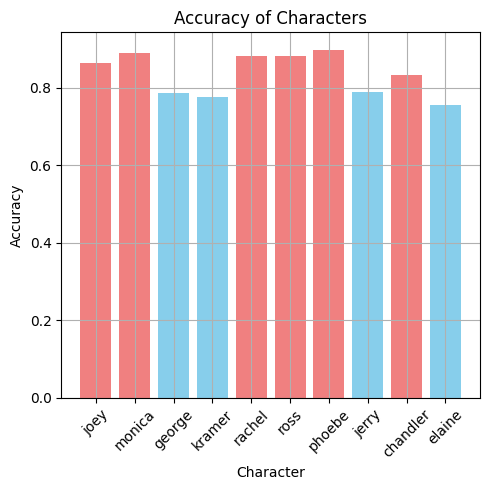

In [ ]:
friends_characters = ['joey', 'phoebe', 'chandler', 'monica', 'ross', 'rachel']
plt.figure(figsize=(5, 5))
for character, values in accuracies.items():
    if character in friends_characters:
        plt.bar(character, values[1], color='lightcoral')
    else:
        plt.bar(character, values[1], color='skyblue')

plt.xlabel('Character')
plt.ylabel('Accuracy')
plt.title('Accuracy of Characters')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# CSV file

In [ ]:
import os

results = {'Test score (Accuracy)': [acc_test[1]],
           'Train score (Accuracy)': [acc_train[1]],
           'Number of trainable parameters': [model.count_params()],
           'Number of layers': [len(model.layers)],
           'Regularization methods': ['GRU, Dropout'],
           'Number of epochs': ['5'],
           'Choise of loss function':['binary_crossentropy'],
           'Choise of optimizer': ['adam'],
           'Embedding dimension' : ['64'],
           }

df = pd.DataFrame(results)
df

,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Choise of loss function,Choise of optimizer,Embedding dimension
0,0.838634,0.863766,1140721,7,"GRU, Dropout",5,binary_crossentropy,adam,64


In [11]:
import os
df.to_csv(os.path.join(os.getcwd(), 'exercise2.csv'))